<a href="https://colab.research.google.com/github/nPr0nn/Machine-Learning-Playground/blob/main/unet_fish_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


# Importing

In [17]:
# Tensorflow
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Matplotlib
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Numpy
import numpy as np

# Opencv
import cv2

# Files management
import os

# Parallelism
import concurrent.futures

# Dataset Pipeline

In [115]:
# Load the dataset
path = "/content/gdrive/Shareddrives/Recod-CIIMAR/ProjI4F-IniCient/Datasets/FishLateral"

folders = ["/fit/image/", "/fit/mask/", "/test/image/", "/test/mask/"]
paths_train_images = [ path + folders[0] + x for x in os.listdir(path + folders[0]) ]
paths_train_masks  = [ path + folders[1] + x for x in os.listdir(path + folders[1]) ]
paths_test_images  = [ path + folders[2] + x for x in os.listdir(path + folders[2]) ]
paths_test_masks   = [ path + folders[3] + x for x in os.listdir(path + folders[3]) ]

paths_train_images.sort()
paths_train_masks.sort()
paths_test_images.sort()
paths_test_masks.sort()

In [116]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_mask(image_path):
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

In [117]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
  train_images = list(executor.map(load_image, paths_train_images))
  train_masks  = list(executor.map(load_mask, paths_train_masks))

In [118]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
  test_images  = list(executor.map(load_image, paths_test_images))
  test_masks   = list(executor.map(load_mask, paths_test_masks))

In [143]:
len(train_masks)

589

In [123]:
# train_images = train_images[0:120]
# train_masks  = train_masks[0:120]
# test_images  = test_images[0:120]
# test_masks   = test_masks[0:120]
# print(len(test_masks))

In [124]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))

In [125]:
test_dataset  = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

In [126]:
# Batch and shuffle the dataset
batch_size = 32
shuffle_buffer_size = 1000

# train
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(shuffle_buffer_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# test
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [127]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

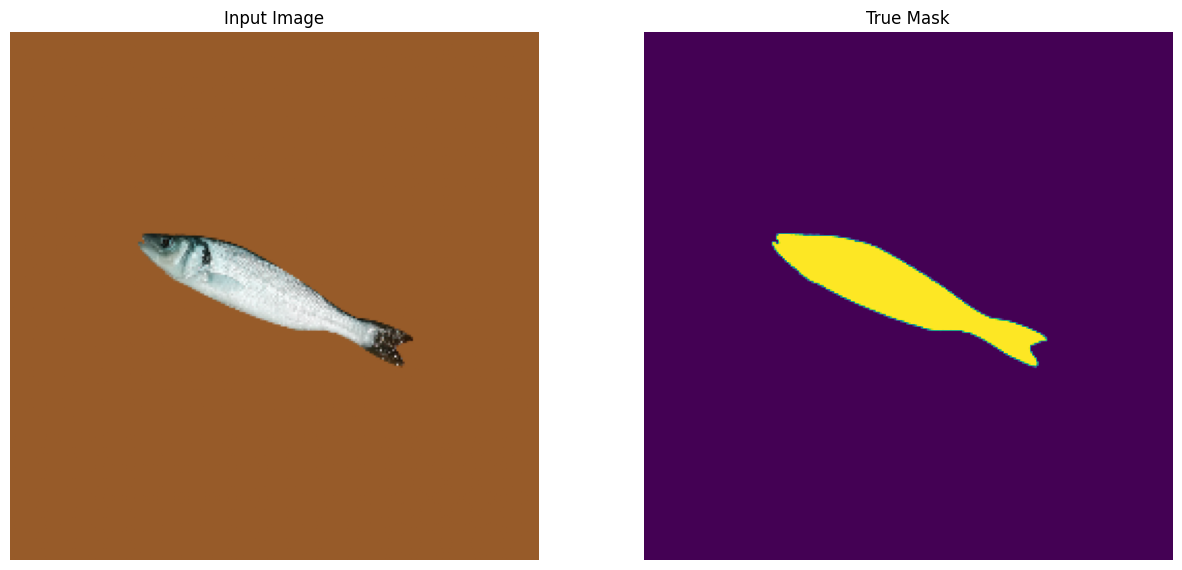

In [128]:
for i in range(1):
  display([test_images[i], test_masks[i]])

# Unet

In [129]:
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


In [130]:
img_shape = [256, 256, 3]

In [131]:
# Down Stack
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model  = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False)
layers      = [base_model.get_layer(name).output for name in layer_names]
down_stack  = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False


In [132]:
# Up Stack
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [133]:
def unet(output_channels):

  # Input layer
  inputs       = tf.keras.layers.Input(shape=img_shape)
  x            = inputs

  # Downsampling
  skips = down_stack(x)
  x     = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Last layer
  last_layer = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same', activation='softmax')  #64x64 -> 128x128
  x = last_layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [134]:
CLASSES_NUMBER = 2
model = unet(CLASSES_NUMBER)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

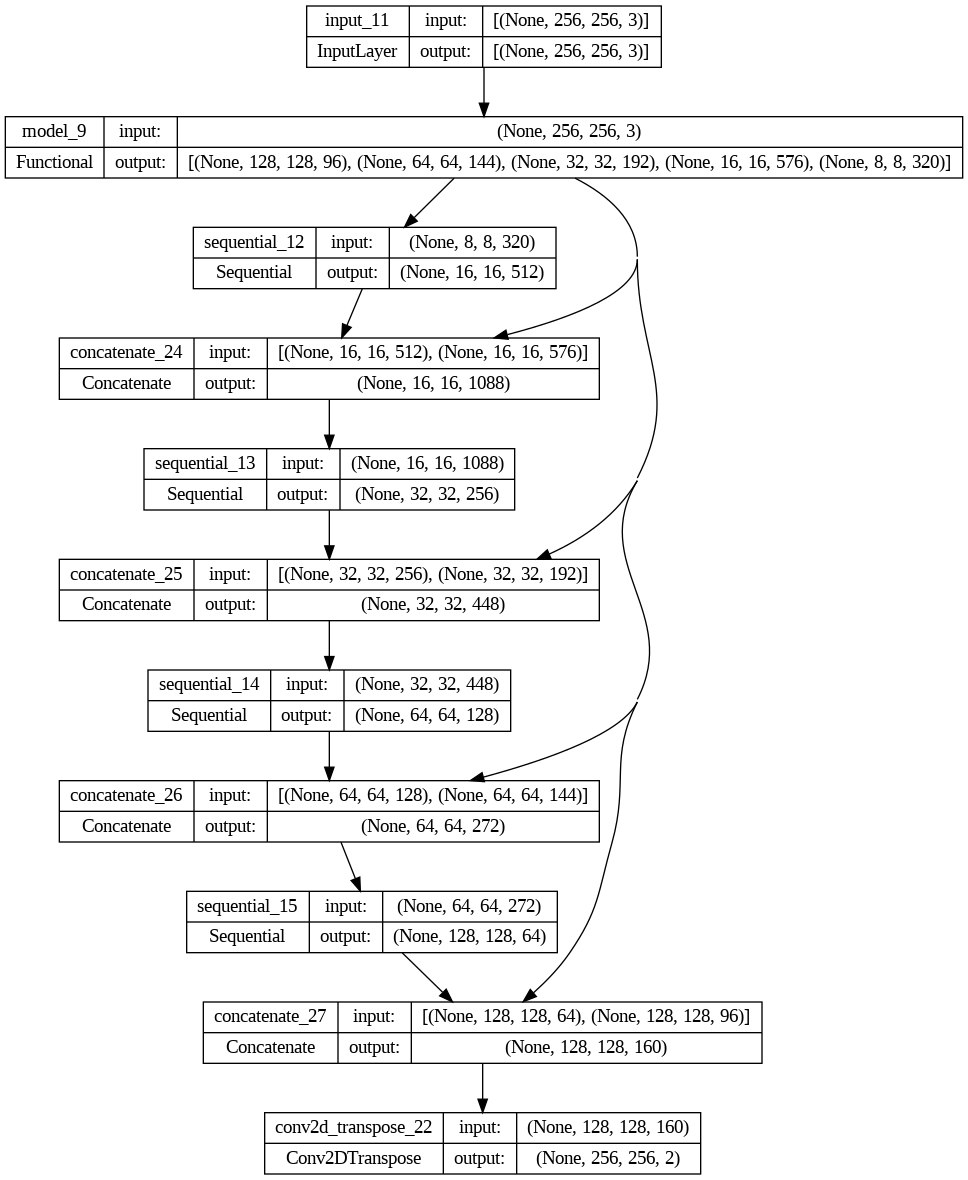

In [135]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [136]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [137]:
# Trainning
TRAIN_LENGTH = len(train_images)
TEST_LENGTH  = len(test_images)

BATCH_SIZE   = 8
STEPS        = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLIT = 5
VAL_STEPS    = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLIT

EPOCHS       = 5

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS,
                    validation_steps=VAL_STEPS,
                    validation_data=test_dataset,
                    callbacks=[cp_callback])

Epoch 1/5
73/73 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9709 
Epoch 1: saving model to training_1/cp.ckpt
73/73 [==============================] - 829s 11s/step - loss: 0.0687 - accuracy: 0.9709 - val_loss: 0.0140 - val_accuracy: 0.9932
Epoch 2/5
73/73 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9963 
Epoch 2: saving model to training_1/cp.ckpt
73/73 [==============================] - 814s 11s/step - loss: 0.0064 - accuracy: 0.9963 - val_loss: 0.0072 - val_accuracy: 0.9954
Epoch 3/5
73/73 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9967 
Epoch 3: saving model to training_1/cp.ckpt
73/73 [==============================] - 805s 11s/step - loss: 0.0041 - accuracy: 0.9967 - val_loss: 0.0054 - val_accuracy: 0.9956
Epoch 4/5
73/73 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9968 
Epoch 4: saving model to training_1/cp.ckpt
73/73 [==============================] - 803s 11s/step 

In [138]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [139]:
model = unet(CLASSES_NUMBER)
model.load_weights(checkpoint_path)

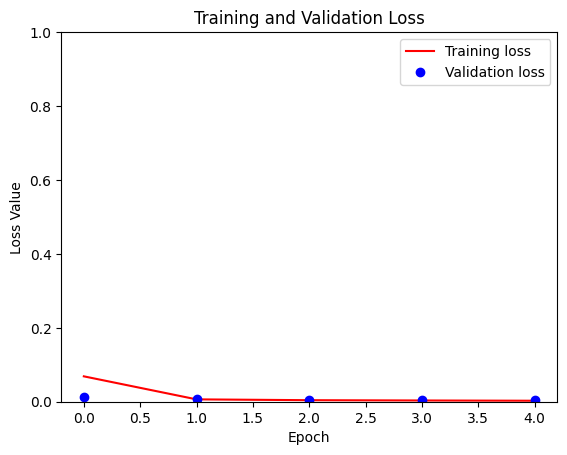

In [140]:
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [141]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 6s 6s/step


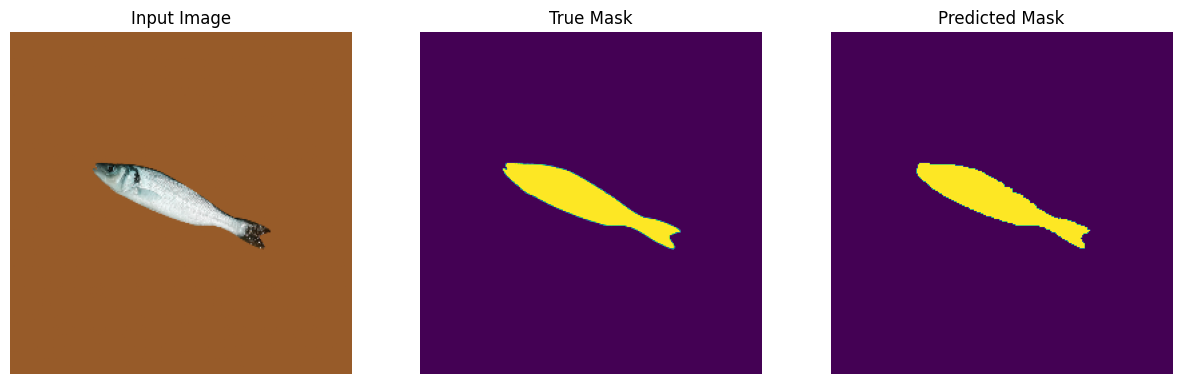

1/1 [==============================] - 7s 7s/step


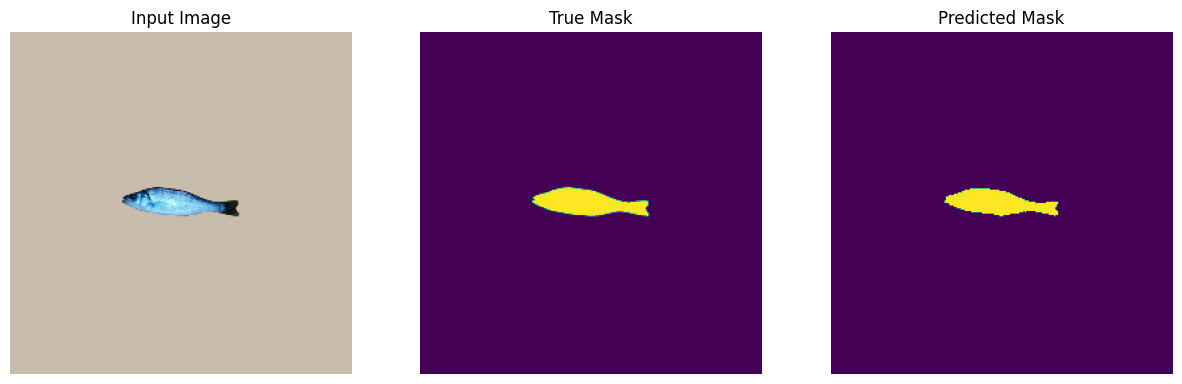

In [142]:
show_predictions(test_dataset, 50)